Total Features Before Selection: 83

Top 30 Selected Features by Correlation:
['Inbound', 'Source Port', 'URG Flag Count', 'RST Flag Count', 'Packet Length Std', 'Bwd Packet Length Std', 'Bwd Packet Length Max', 'Fwd Packet Length Std', 'Packet Length Variance', 'Avg Bwd Segment Size', 'Bwd Packet Length Mean', 'Max Packet Length', 'Bwd IAT Total', 'Bwd IAT Max', 'Flow Duration', 'Flow IAT Max', 'Fwd IAT Total', 'Idle Mean', 'Idle Min', 'Fwd IAT Max', 'Idle Max', 'Bwd IAT Std', 'Bwd IAT Mean', 'Fwd IAT Std', 'Flow IAT Std', 'Bwd Packets/s', 'Total Length of Fwd Packets', 'Subflow Fwd Bytes', 'Init_Win_bytes_backward', 'Subflow Fwd Packets']

Total Selected Features: 30


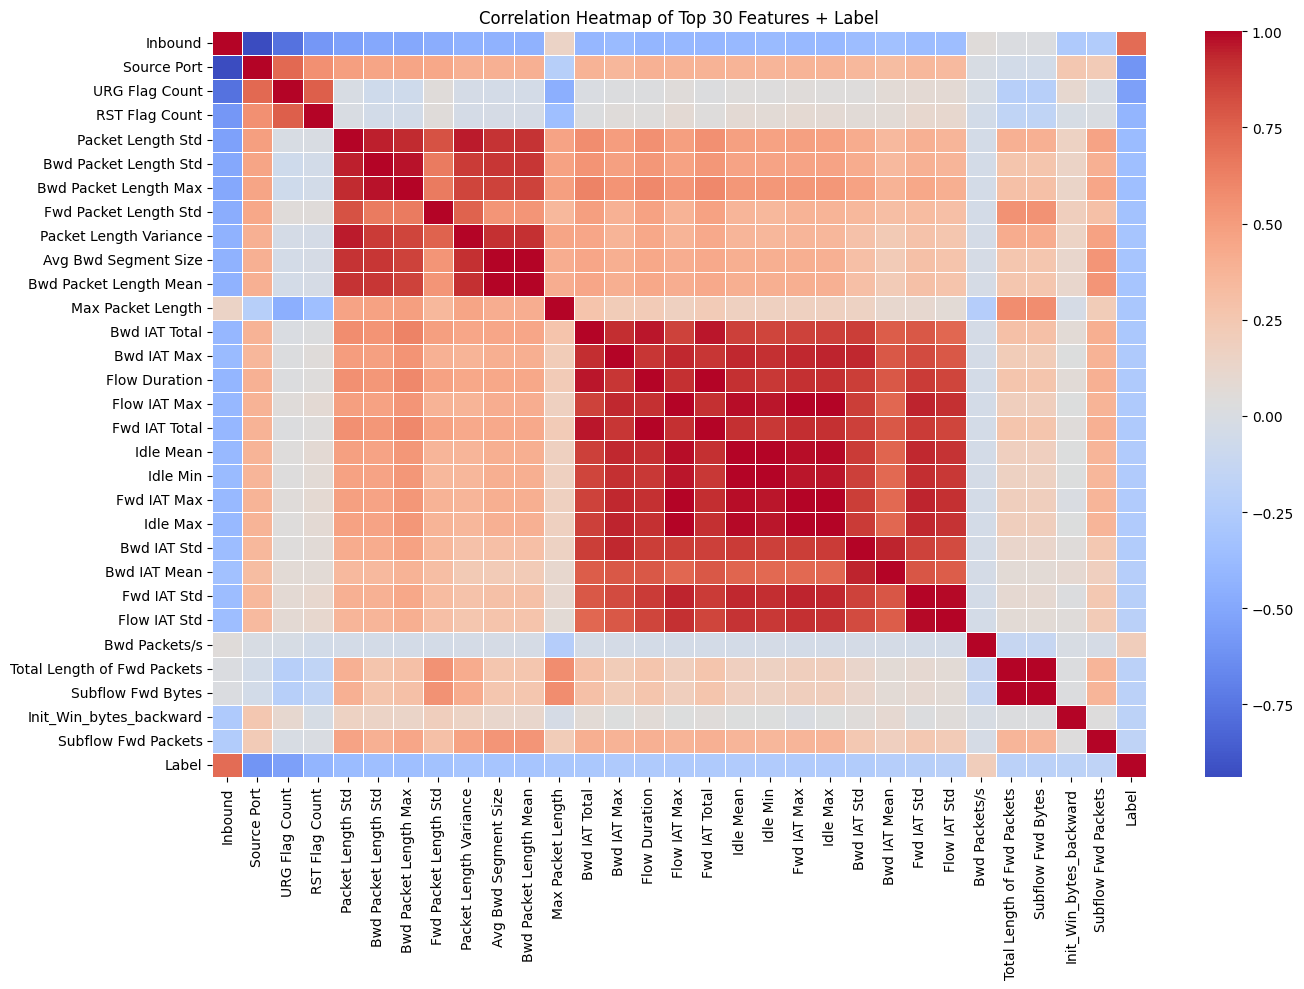

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load Dataset
file_path = "E:\\TLS_Balanced_Attacks_Fixed.csv"
tls_traffic = pd.read_csv(file_path)

# Clean column names (remove spaces)
tls_traffic.columns = tls_traffic.columns.str.strip()

# Identify the target column (attack type)
target_column = "Label"

# Convert categorical target variable (Label) to numerical for correlation analysis
label_encoder = LabelEncoder()
tls_traffic[target_column] = label_encoder.fit_transform(tls_traffic[target_column])

# Convert numeric columns to float32 for memory efficiency
numeric_cols = tls_traffic.select_dtypes(include=['float64', 'int64']).columns
tls_traffic[numeric_cols] = tls_traffic[numeric_cols].astype(np.float32)

# Print total number of features before selection
print(f"Total Features Before Selection: {tls_traffic.shape[1] - 2}")  # Excluding Label & Timestamp

# Compute correlation matrix and extract correlation with target
correlation_matrix = tls_traffic.corr(numeric_only=True)
target_correlation = correlation_matrix[target_column].drop(target_column, errors="ignore")

# Drop known noisy or irrelevant features (but KEEP timestamp for later)
identifiers_to_remove = ['Unnamed: 0', 'CWE Flag Count', 'ACK Flag Count', 'Fwd PSH Flags']
target_correlation = target_correlation.drop(index=identifiers_to_remove, errors='ignore')

# Select Top 30 features by absolute correlation
top_k = 30
selected_features = target_correlation.abs().sort_values(ascending=False).head(top_k).index.tolist()

# Print selected features
print("\nTop 30 Selected Features by Correlation:")
print(selected_features)
print(f"\nTotal Selected Features: {len(selected_features)}")

# Keep only top 30 features + Label + Timestamp
tls_traffic = tls_traffic[selected_features + [target_column, "Timestamp"]]

# Save processed dataset
output_file_path = "E:\\TLS_Top30_Selected_Features.csv"
tls_traffic.to_csv(output_file_path, index=False)

# Visualise correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(tls_traffic.corr(numeric_only=True), cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Top 30 Features + Label")
plt.tight_layout()
plt.show()

In [38]:
from sklearn.preprocessing import OneHotEncoder

# Identify the target column
target_column = "Label"

# Initialize One-Hot Encoder
ohe = OneHotEncoder(sparse_output=False)  # Updated to avoid warning

# Apply One-Hot Encoding to "Label" column
encoded_labels = ohe.fit_transform(tls_traffic[[target_column]])

# Create column names for the new encoded classes
ohe_columns = ohe.get_feature_names_out([target_column])

# Convert encoded labels into a DataFrame
encoded_labels_df = pd.DataFrame(encoded_labels, columns=ohe_columns)

# Merge One-Hot Encoded Labels with the dataset (drop original Label column)
tls_traffic = pd.concat([tls_traffic.drop(columns=[target_column]), encoded_labels_df], axis=1)

# Define the output file path
output_file_path = "E:\\TLS_OneHotEncoded.csv"

# Save the processed dataset to CSV
tls_traffic.to_csv(output_file_path, index=False)

# Display dataset shape and new column names
print(f"Dataset shape after One-Hot Encoding: {tls_traffic.shape}")
print(f"New Columns After Encoding: {ohe_columns.tolist()}")
print(f"One-Hot Encoded dataset saved successfully at: {output_file_path}")

# Show first few rows to verify encoding
print(tls_traffic.head())

Dataset shape after One-Hot Encoding: (179032, 36)
New Columns After Encoding: ['Label_0', 'Label_1', 'Label_2', 'Label_3', 'Label_4']
One-Hot Encoded dataset saved successfully at: E:\TLS_OneHotEncoded.csv
   Inbound  Source Port  URG Flag Count  RST Flag Count  Packet Length Std  \
0      1.0        564.0             0.0             0.0                0.0   
1      1.0        564.0             0.0             0.0                0.0   
2      1.0        564.0             0.0             0.0                0.0   
3      1.0        864.0             0.0             0.0                0.0   
4      1.0        564.0             0.0             0.0                0.0   

   Bwd Packet Length Std  Bwd Packet Length Max  Fwd Packet Length Std  \
0                    0.0                    0.0                    0.0   
1                    0.0                    0.0                    0.0   
2                    0.0                    0.0                    0.0   
3                    0.0    

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Identify the feature columns (excluding timestamp and label columns)
target_columns = [col for col in tls_traffic.columns if col.startswith("Label_")]
feature_columns = [col for col in tls_traffic.columns if col not in target_columns + ["Timestamp"]]

# First, split into Training (70%) and Remaining (30%)
X_train, X_rem, y_train, y_rem = train_test_split(
    tls_traffic[feature_columns], tls_traffic[target_columns], 
    test_size=0.3, random_state=42, stratify=tls_traffic[target_columns]
)

# Then, split the remaining 30% into Validation (15%) and Testing (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_rem, y_rem, 
    test_size=0.5, random_state=42, stratify=y_rem
)

# Print dataset shapes
print(f"Training Set Shape: {X_train.shape}, {y_train.shape}")
print(f"Validation Set Shape: {X_val.shape}, {y_val.shape}")
print(f"Testing Set Shape: {X_test.shape}, {y_test.shape}")

# Confirm Train/Val/Test Split Completed Successfully
print("Dataset splitting into Train (70%), Validation (15%), and Test (15%) is complete!")

Training Set Shape: (125322, 30), (125322, 5)
Validation Set Shape: (26855, 30), (26855, 5)
Testing Set Shape: (26855, 30), (26855, 5)
Dataset splitting into Train (70%), Validation (15%), and Test (15%) is complete!


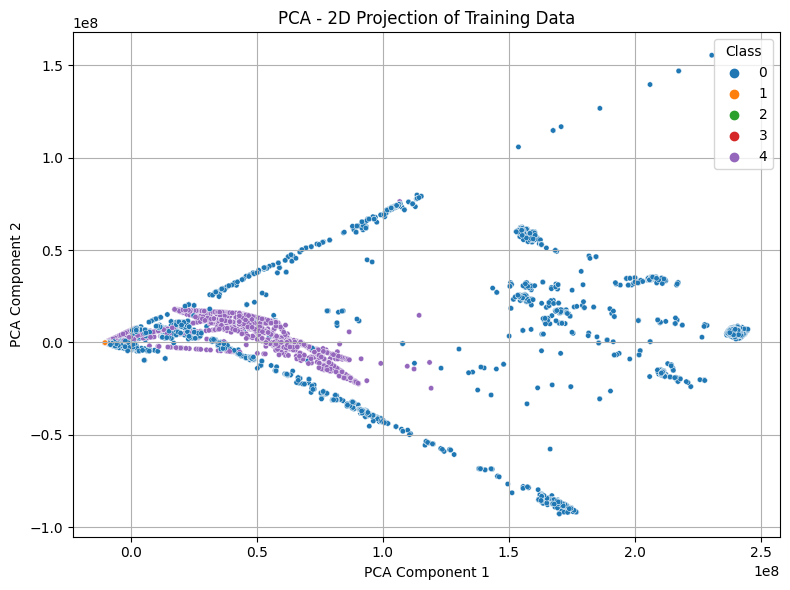

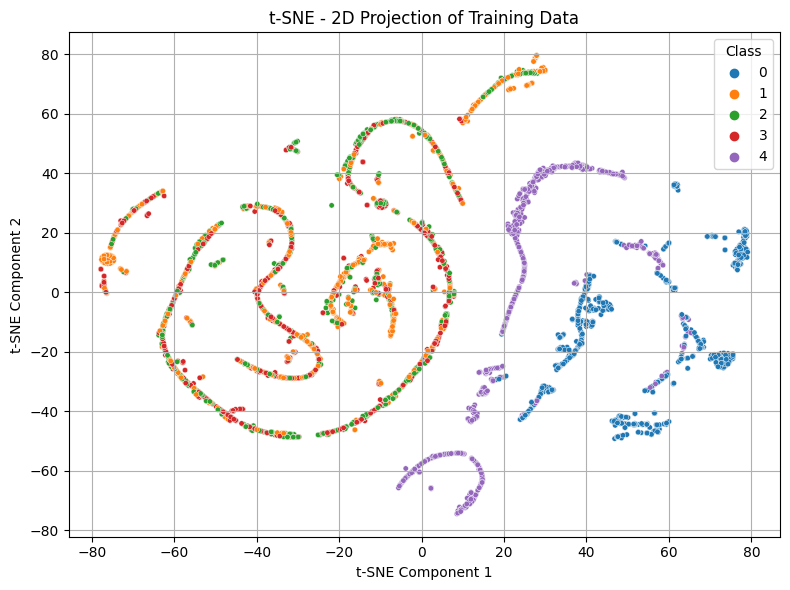

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Use integer labels for visualization
y_train_labels = y_train.idxmax(axis=1).apply(lambda x: int(x.split('_')[1]))

# ---------------------- PCA ----------------------
pca = PCA(n_components=2, random_state=42)
X_train_pca = pca.fit_transform(X_train)

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train_labels, palette="tab10", s=15)
plt.title("PCA - 2D Projection of Training Data")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Class', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------- t-SNE ----------------------
# Note: t-SNE is computationally heavy. Consider sampling if dataset is large
sample_size = 5000  # Optional: reduce for speed
X_sample = X_train[:sample_size]
y_sample_labels = y_train_labels[:sample_size]

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, learning_rate='auto', init='pca', random_state=42)
X_train_tsne = tsne.fit_transform(X_sample)

# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=y_sample_labels, palette="tab10", s=15)
plt.title("t-SNE - 2D Projection of Training Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title='Class', loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import os
import pennylane as qml
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create directory for saving the model
os.makedirs("trained_models", exist_ok=True)

# Increase Quantum Features
num_qubits = 6  

# Extract Quantum & Classical Features
quantum_features = X_train.iloc[:, :num_qubits]  
classical_features = X_train.iloc[:, num_qubits:]  

# Define Quantum Device
dev = qml.device("default.qubit", wires=num_qubits)

# Quantum Circuit with Hadamard Gates (Superposition) + AmplitudeEmbedding
@qml.qnode(dev, interface="tf")
def quantum_circuit(inputs, weights):
    batch_size = tf.shape(inputs)[0]
    feature_size = tf.shape(inputs)[1]

    # Pad input to match 2^n dimensions
    padded_inputs = tf.concat(
        [inputs, tf.zeros([batch_size, 2**num_qubits - feature_size])], axis=1
    )

    # Step 1: Apply Hadamard gates to all qubits for superposition
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)

    # Step 2: Apply Amplitude Embedding
    qml.AmplitudeEmbedding(padded_inputs[0], wires=range(num_qubits), normalize=True, pad_with=0.0)

    # Step 3: Apply Entangling Layers
    qml.StronglyEntanglingLayers(weights, wires=range(num_qubits))

    # Step 4: Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

# Define Quantum Layer
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, num_qubits, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.num_qubits = num_qubits
        self.q_weights = self.add_weight(
            name="q_weights", shape=(2, num_qubits, 3), initializer="glorot_uniform", trainable=True
        )

    def call(self, inputs):
        ta = tf.TensorArray(dtype=tf.float32, size=tf.shape(inputs)[0])

        def loop_body(i, ta):
            out = quantum_circuit(tf.expand_dims(inputs[i], axis=0), self.q_weights)
            return i + 1, ta.write(i, out)

        _, ta = tf.while_loop(lambda i, _: i < tf.shape(inputs)[0], loop_body, [0, ta])
        return ta.stack()

    def get_config(self):
        config = super().get_config()
        config.update({"num_qubits": self.num_qubits})
        return config

# Define Hybrid Quantum-Classical Model
def create_hybrid_model(num_qubits, num_features, num_classes):
    input_q = tf.keras.layers.Input(shape=(num_qubits,))
    input_c = tf.keras.layers.Input(shape=(num_features - num_qubits,))

    # Quantum Path
    q_layer = QuantumLayer(num_qubits)(input_q)
    q_layer = tf.keras.layers.Dense(64, activation="relu")(q_layer)

    # Classical Path
    c_layer = tf.keras.layers.Dense(128, activation="relu")(input_c)
    c_layer = tf.keras.layers.BatchNormalization()(c_layer)
    c_layer = tf.keras.layers.Dropout(0.4)(c_layer)
    c_layer = tf.keras.layers.Dense(64, activation="relu")(c_layer)
    c_layer = tf.keras.layers.BatchNormalization()(c_layer)
    c_layer = tf.keras.layers.Dropout(0.4)(c_layer)

    # Fusion Layer
    combined = tf.keras.layers.concatenate([q_layer, c_layer])
    combined = tf.keras.layers.Dense(64, activation="relu")(combined)
    combined = tf.keras.layers.BatchNormalization()(combined)
    combined = tf.keras.layers.Dropout(0.3)(combined)

    # Output Layer
    output = tf.keras.layers.Dense(num_classes, activation="softmax")(combined)

    model = tf.keras.models.Model(inputs=[input_q, input_c], outputs=output)
    return model

# Get Number of Classes from One-Hot Encoded Labels
num_classes = y_train.shape[1]

# Initialize & Compile Model
hybrid_model = create_hybrid_model(num_qubits, X_train.shape[1], num_classes)
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
)

# Ensure Labels Are in Correct Format
y_train_split = np.array(y_train, dtype=np.float32)
y_val_split = np.array(y_val, dtype=np.float32)

# Split Training & Validation Data for Quantum-Classical Inputs
X_train_q, X_val_q, X_train_c, X_val_c, y_train_split, y_val_split = train_test_split(
    quantum_features, classical_features, y_train_split,
    test_size=0.2, random_state=42, stratify=y_train
)

# Custom Batch Generator
class CustomBatchGenerator(tf.keras.utils.Sequence):
    def __init__(self, X_q, X_c, y, batch_size):
        self.X_q = X_q
        self.X_c = X_c
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.y) / self.batch_size))

    def __getitem__(self, idx):
        batch_X_q = self.X_q[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_c = self.X_c[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return [batch_X_q, batch_X_c], batch_y

# Initialize Training & Validation Generators
train_generator = CustomBatchGenerator(X_train_q, X_train_c, y_train_split, batch_size=64)
val_generator = CustomBatchGenerator(X_val_q, X_val_c, y_val_split, batch_size=64)

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5)

# Train the Hybrid Quantum-Classical Model
history = hybrid_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    verbose=1,
    callbacks=[lr_scheduler]
)

# Save the Trained Model
hybrid_model.save("trained_models/QNN_DDos2019.h5")


Starting training progress:

Epoch 1/50
1958/1958 [==============================] - loss: 0.6998 - accuracy: 0.6051 - precision: 0.8039 - recall: 0.4064 - val_loss: 0.7498 - val_accuracy: 0.5851
Epoch 2/50
1958/1958 [==============================] - loss: 0.7019 - accuracy: 0.6084 - precision: 0.8069 - recall: 0.4099 - val_loss: 0.7519 - val_accuracy: 0.5884
Epoch 3/50
1958/1958 [==============================] - loss: 0.7032 - accuracy: 0.6111 - precision: 0.8093 - recall: 0.4129 - val_loss: 0.7532 - val_accuracy: 0.5911
Epoch 4/50
1958/1958 [==============================] - loss: 0.7036 - accuracy: 0.6132 - precision: 0.8110 - recall: 0.4154 - val_loss: 0.7536 - val_accuracy: 0.5932
Epoch 5/50
1958/1958 [==============================] - loss: 0.7028 - accuracy: 0.6145 - precision: 0.8118 - recall: 0.4172 - val_loss: 0.7528 - val_accuracy: 0.5945
Epoch 6/50
1958/1958 [==============================] - loss: 0.7008 - accuracy: 0.6150 - precision: 0.8117 - recall: 0.4183 - val_loss

Final Training Accuracy: 0.8483
Final Validation Accuracy: 0.8283


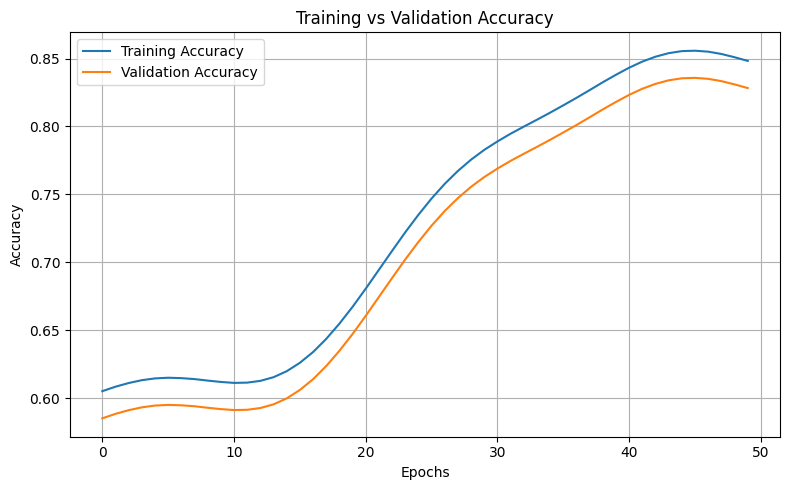

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

print(f"Final Training Accuracy: {train_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracy[-1]:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.text(epochs[-1], train_accuracy[-1], f'{train_accuracy[-1]:.4f}', va='bottom', ha='right')
plt.text(epochs[-1], val_accuracy[-1], f'{val_accuracy[-1]:.4f}', va='bottom', ha='right')
plt.tight_layout()
plt.show()

Final Precision: 0.8993
Final Recall: 0.7973


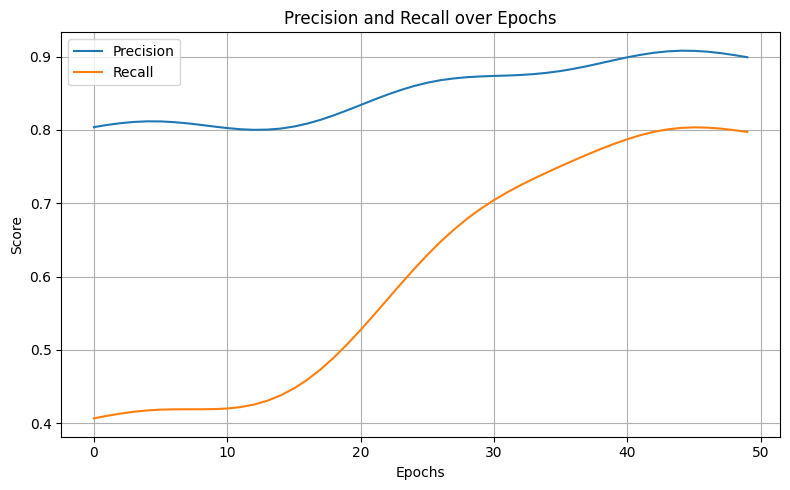

In [ ]:
precision = history.history['precision']
recall = history.history['recall']

print(f"Final Precision: {precision[-1]:.4f}")
print(f"Final Recall: {recall[-1]:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Precision and Recall over Epochs')
plt.legend()
plt.grid(True)
plt.text(epochs[-1], precision[-1], f'{precision[-1]:.4f}', va='bottom', ha='right')
plt.text(epochs[-1], recall[-1], f'{recall[-1]:.4f}', va='bottom', ha='right')
plt.tight_layout()
plt.show()

Final F1 Score: 0.8452


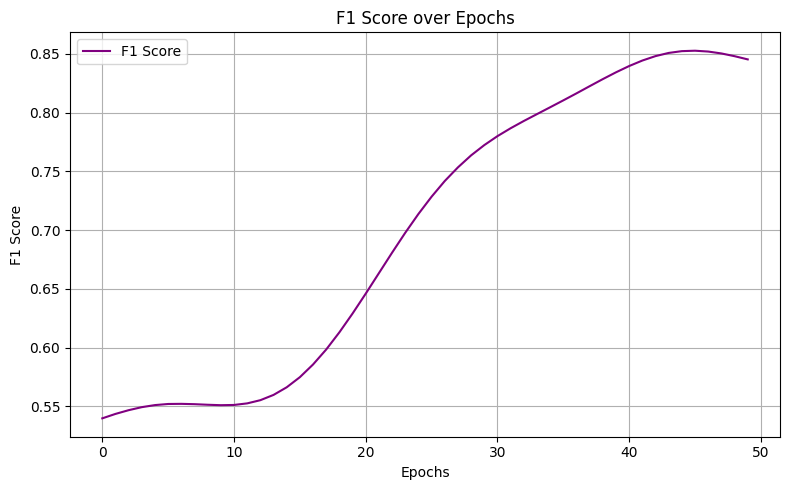

In [ ]:
f1_score = [2 * p * r / (p + r) if (p + r) != 0 else 0 for p, r in zip(precision, recall)]

print(f"Final F1 Score: {f1_score[-1]:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(epochs, f1_score, label='F1 Score', color='purple')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.legend()
plt.grid(True)
plt.text(epochs[-1], f1_score[-1], f'{f1_score[-1]:.4f}', va='bottom', ha='right')
plt.tight_layout()
plt.show()

Final Training Loss: 0.3027
Final Validation Loss: 0.3527


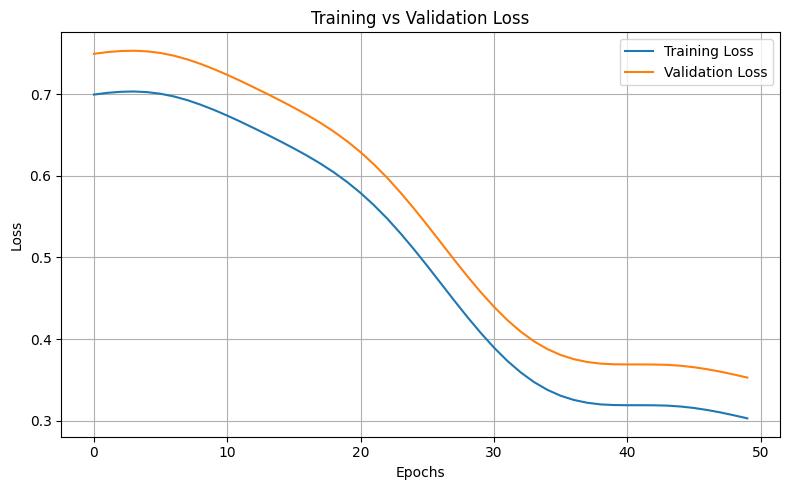

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Final Training Loss: {train_loss[-1]:.4f}")
print(f"Final Validation Loss: {val_loss[-1]:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.text(epochs[-1], train_loss[-1], f'{train_loss[-1]:.4f}', va='bottom', ha='right')
plt.text(epochs[-1], val_loss[-1], f'{val_loss[-1]:.4f}', va='bottom', ha='right')
plt.tight_layout()
plt.show()

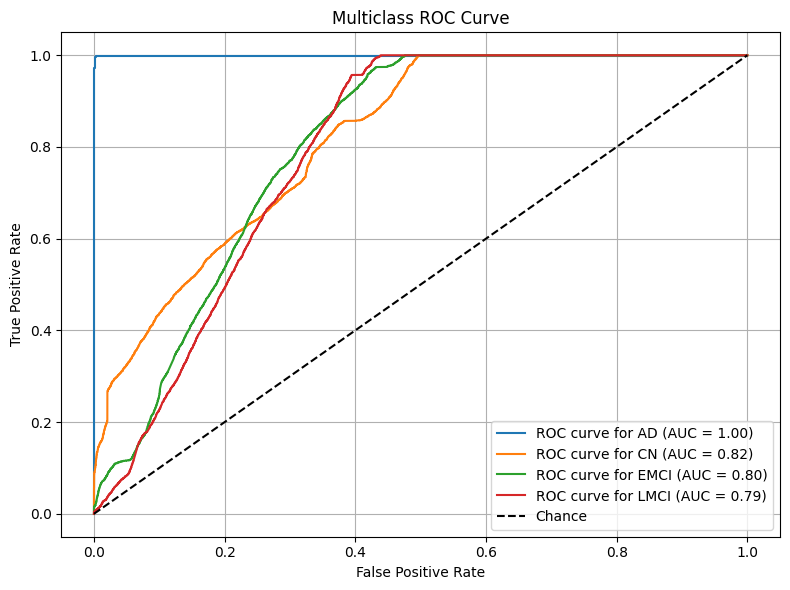

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Make predictions on your test set
# Use val_generator, test_generator, or X_val/X_test depending on your setup
# Here we assume you have the test data: X_test_q and X_test_c, and true labels y_test

# Get predictions
y_pred_probs = hybrid_model.predict([X_test.iloc[:, :num_qubits], X_test.iloc[:, num_qubits:]])

# Convert one-hot to class indices
y_true = np.argmax(y_test.values, axis=1)
y_pred_bin = y_pred_probs  # already softmax outputs

# Class names (adjust if needed)
class_names = ['AD', 'CN', 'EMCI', 'LMCI']
n_classes = len(class_names)

# Binarize the true labels
y_test_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Step 2: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 3: Plot the ROC Curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()